# Variational Quantum Eigensolver on Ascella

This notebook performs a VQE [1,2] either on a local Ascella simulator, or on Quandela Cloud, by mapping phases directly on to the layout of the chip. It requires a cloud token.

The overall idea of the VQE algorithm is to optimise the value of: $E_0 \leq \langle {\psi (\theta)} | \hat H |  {\psi (\theta)} \rangle$.

This notebook walks through the steps to do so.


<img src="/Users/pe/codes/perceval/VQE/VQE1.png" width="1000" align="center"/>

In [1]:
# OpenFermion
from openfermionpyscf import generate_molecular_hamiltonian
from openfermion.chem import MolecularData
from openfermion import get_fermion_operator
from openfermion import symmetry_conserving_bravyi_kitaev

# Perceval
import perceval as pcvl

# Numpy
import numpy as np

# Optimize
from scipy.optimize import minimize

# Other useful packages
import time
from IPython import display
import matplotlib.pyplot as plt
from copy import deepcopy


To run jobs on the [Quandela cloud](https://cloud.quandela.com) you should create an account to get a token that you can enter in the cell below.

In [2]:
token_qcloud = ''

## Obtaining the Hamiltonian from OpenFermion

*OpenFermion* [3] allows to generate the target Hamiltonian for the system of interest (here a H$_2$ molecule for instance). It can be used as the following:

In [3]:
basis = 'sto-3g' 
# This is our choice of basis set. STO-nG basis sets are minimal basis sets, where n primitive Gaussian orbitals are fitted to a single Slater-type orbital (STO). STO-3G is the best choice for our problem. More info here: https://en.wikipedia.org/wiki/STO-nG_basis_sets

multiplicity = 1 
# The multiplicity of a chemical bond is determined by the number of electron pairs that occupy the region between the two bonded atoms in bonding molecular orbitals, in our case it is 1.

geometry = [('H', (0.,  0., 0.)), ('H', (0., 0., 0.7414))] 
# 2 H atoms separated by 0.7414 Angstrom on the z axis

molecule = MolecularData(geometry, basis, multiplicity) 
# This function builds our molecule object where we can find information about the molecule.

Mol_Ham = generate_molecular_hamiltonian(geometry,basis,multiplicity) 
# We generate our molecular Hamiltonian, writing it in terms of electronic orbitals

Ferm = get_fermion_operator(Mol_Ham) 
# Here we create the fermionic operator of our Hamiltonian, which is the hamiltonian in terms of creation and annihilation operators.

qubit_hamiltonian = symmetry_conserving_bravyi_kitaev(Ferm, 4, 2) 
# Then we have our Fermion to Qubit mapping, this transforms the fermionic hamiltonian to the qubit hamiltonian used for the VQE, other examples include Jordan Wigner and Bravyi Kitaev.

print(qubit_hamiltonian) 
# Display the hamiltonian

-0.3399536134414944 [] +
0.1812888082114959 [X0 X1] +
0.3939836794385142 [Z0] +
0.01123658523318205 [Z0 Z1] +
0.39398367943851414 [Z1]


We can iterate this procedure by looping over bound lengths of interest to get the coefficients of the effective Hamiltonian and then obtain the ground state energy for varying bound lengths.

In [4]:
# Qubit Hamiltonian for Optimal Radius of H2
h_names = [
    'II',
    'ZI',
    'IZ',
    'ZZ',
    'XX']
h_weights = [
    -0.33992710211913285,
    0.3939976345768911,
    0.3939976345768911,
    0.011236740873436846,
    0.1812875356724251]

## Functions for Fock states to qubit states

First we need to define the function that will identify the qubits to be measured for calculation of the energy, we also need to translate from the photonic Fock basis to the Qubit Hilbert basis.


In [5]:
def measures(pauli_string: str) -> list:
    """This function takes a Pauli string and returns exactly which qubits are relevant to be measured."""
    measured_qubits = []
    for i, pauli_op in enumerate(pauli_string):

        #If the Pauli is a Z or an X, we measure the corresponding qubit, whereas when it is an I the qubit is not measured.
        if pauli_op == "X":
            measured_qubits.append(i)
            
        if pauli_op == "Z":
            measured_qubits.append(i)
    
    return measured_qubits 

def Photon_to_Qubit(state: pcvl.BasicState) -> np.array:
    """This function takes a state in the photonic basis and translate it in to the Qubit basis which is relevant for VQE."""

    numpy_state = np.array(state[:len(state)]) #Changing the Basicstate object to a numpy array
    
    numpy_state = np.delete(numpy_state,[0,1,5,6,7,8,9,10]) #Deleting the Ancillary modes so we are only left with modes of interest

    Qubit_state = np.zeros(numpy_state.size // 2) #Setting the size of the Qubit state
    
    #The following block changes the relevant photonic modes in to the Qubit basis.
    for i in range(0, numpy_state.size, 2):
        if numpy_state[i] == 0:
            Qubit_state[i // 2] = 1
        else:
            Qubit_state[i // 2] = 0  


    
    return Qubit_state

#Example
print("|0,0,1,0,1,0,0,0,0,0,0,0> is interpreted as ",Photon_to_Qubit(pcvl.BasicState([0,0,1,0,1,0,0,0,0,0,0,0])))
print("|0,0,1,0,0,1,0,0,0,0,0,0> is interpreted as ",Photon_to_Qubit(pcvl.BasicState([0,0,1,0,0,1,0,0,0,0,0,0])))
print("|0,0,0,1,1,0,0,0,0,0,0,0> is interpreted as ",Photon_to_Qubit(pcvl.BasicState([0,0,0,1,1,0,0,0,0,0,0,0])))
print("|0,0,0,1,0,1,0,0,0,0,0,0> is interpreted as ",Photon_to_Qubit(pcvl.BasicState([0,0,0,1,0,1,0,0,0,0,0,0])))

|0,0,1,0,1,0,0,0,0,0,0,0> is interpreted as  [0. 0.]
|0,0,1,0,0,1,0,0,0,0,0,0> is interpreted as  [0. 1.]
|0,0,0,1,1,0,0,0,0,0,0,0> is interpreted as  [1. 0.]
|0,0,0,1,0,1,0,0,0,0,0,0> is interpreted as  [1. 1.]


## Functions to set phases on Ascella

Next we define the functions that will map the parameters to the values of the phases to set on Ascella. We need a function (i) to bring the chip back to identity, (ii) a CNOT gate for entanglement (green block) and (iii) Hadamard gates for basis rotation (orange phase-shifters). The CNOT and Hadamard gates have been optimised by the transpilation algorithm so that the phases have been pre-computed.


<img src="/Users/pe/codes/perceval/VQE/VQE2.png" width="1000" align="center"/>

In [6]:
def set_phases_cnot_new(chip_params):
    """Set-up optimized cnot gate on 1scella chip starting at position 12

        chip_params: parameters of the chip
    """

    # List of values obtained by transpilation for the CNOT
    opt_cnot_on_ascella_new = {34: 0.717409337404176,
                               35: 1.11707773166768,
                               36: 3.14159781999088,
                               37: 3.37307200960087,
                               38: 3.14160504367710,
                               39: 4.07326092027237,
                               46: 3.14159002437864,
                               47: 2.17828831668636,
                               48: 4.72958177994030,
                               49: 0.192686625451998,
                               56: 4.83803136449134,
                               57: 2.05109237059823,
                               58: 1.20654363849305,
                               59: 2.12774383027317,
                               60: 5.07665821117925,
                               61: 2.16109990214002,
                               68: 3.14160617038599,
                               69: 2.84953160140033,
                               70: 1.55361692035105,
                               71: 3.27308092256776}

    # Set the values in the chip
    for idx, values in opt_cnot_on_ascella_new.items():
        chip_params[idx].set_value(values)
    pass
        
def set_phases_identity(params):
    """ This function sets the full chip to be identity
    """
    for idx, p in enumerate(params):
        if idx in (101,112,103,114): #Leaves the hadamard phases blank
            continue
        if idx in [7,8,9,10,11,18,19,20,21,29,30,31,32,33,40,41,42,43,51,52,53,54,55,62,63,64,65,73,74,75,76,77,
                   84,85,86,87,95,96,97,98,99,106,107,108,109,117,118,119,120,121,128,129,130,131,123,127] or idx%2==1:
            p.set_value(0)
        else:
            p.set_value(np.pi) #The rest of the phases are set for identity
    pass

def get_phases_hadamard_gate():
    """Get phases for Hadamard gate for the X measurement"""
    return {101: np.pi/2, 112: -np.pi/2, 103: np.pi/2, 114: -np.pi/2 }


def get_phases_identity_gate():
    """Get phases for identity for Z measurement"""
    return {p: float(p%2==0 and np.pi or 0) for p in (101,112,103,114)}



Next we define the function which takes the variable parameters of the circuit on which we actually perform the learning algorithm and assigns them a value. They correspond to the black phase-shifters on the figure above.

In [7]:
def set_phases_variables(chip_params, lp):

    """These are the variable parameters for the optimisation, 
       Chip_params are the parameters of the chip
       lp are the variables used for optimisation"""

    chip_params[2].set_value(lp[0])
    chip_params[3].set_value(lp[1])
    chip_params[4].set_value(lp[2])
    chip_params[5].set_value(lp[3])
    chip_params[12].set_value(lp[4])
    chip_params[13].set_value(lp[5])
    chip_params[14].set_value(lp[6])
    chip_params[15].set_value(lp[7])
    chip_params[24].set_value(lp[8])
    chip_params[25].set_value(lp[9])
    chip_params[26].set_value(lp[10])
    chip_params[27].set_value(lp[11])
    chip_params[78].set_value(lp[12])
    chip_params[79].set_value(lp[13])
    chip_params[80].set_value(lp[14])
    chip_params[81].set_value(lp[15])
    chip_params[90].set_value(lp[16])
    chip_params[91].set_value(lp[17])
    chip_params[92].set_value(lp[17])
    chip_params[93].set_value(lp[19])
    chip_params[100].set_value(lp[18])
    chip_params[102].set_value(lp[19])

    pass

## Error mitigation

We also use an error mitigation scheme to suppress state preparation and measurement error errors and that allow us to more consistently converge to the optimal ground state energy. We directly define the inverse matrices $\Gamma^{-1}_b$ for Z and X basis measurements that we have pre-computed in a separate code.

In [8]:
Error_Matrix_X = np.array([
                        [1.0000001, -0.026, -0.026, 0],
                        [-0.000000025, 1.0435, 0, -0.000000025],
                        [-0.000000025, 0, 1.0435, -0.000000025],
                        [0, -0.026, -.026, 1.00000001]
                          ])

Error_matrix_Z = np.array([
                        [1.0000001, -0.033, -0.033, 0],
                        [-0.000000025, 1.065, 0, -0.000000025],
                        [-0.000000025, 0, 1.065, -0.000000025],
                        [0, -0.033, -0.033, 1.0000001]
                          ])

## Loss function

We now define the functions that construct expectation values in the Z and X basis. For a given state $\psi$, the following functions compute the average values $<\psi|ZI|\psi>$, $<\psi|IZ|\psi>$, $<\psi|ZZ|\psi>$ and $<\psi|XX|\psi>$

In [9]:
# Fock states corresponding the logical states |00>, |01>, |10> and |11>
output_states = [pcvl.BasicState([0,0,1,0,1,0,0,0,0,0,0,0]),
                 pcvl.BasicState([0,0,1,0,0,1,0,0,0,0,0,0]),
                 pcvl.BasicState([0,0,0,1,1,0,0,0,0,0,0,0]),
                 pcvl.BasicState([0,0,0,1,0,1,0,0,0,0,0,0])]


def compute_weighted_average_Z(h_names, h_weights, s, processor) -> float:

    r"""Compute the expectation values of operators in the Z-basis.

    We take as input the Pauli words (h_names), and the weights corresponding to each Pauli word (h_weights).
    Also we take the index s and the processor (circuit) we have built for the measurement
    """

    measured_qubits = [0,0,0,0] # Here we set up the array to store which qubits are measured for each Pauli word.

    for i in range(4):
        measured_qubits[i] = measures(h_names[i]) 
    #We use the function from earlier to see which qubits are measured for each Pauli word.

    avg = 0
    results = s['results']
    total_samples = 0
    results_vector = []


    for output_state in output_states:
        total_samples +=results[output_state]
    #We calculate the total valid samples which will be used for averaging.

    for output_state in output_states:
        results_vector.append(results[output_state]/total_samples)
    #We create a vector which stores the probability of measuring each state.


    results_vector = np.array(results_vector)

    if processor.name == 'Local processor': # No error mitigation in Local simulation.
        pass

    else: # error mitigate the result if run on the cloud.
        results_vector = Error_matrix_Z @ results_vector

    results_vector = results_vector/np.linalg.norm(results_vector,ord=1) #Normalise the results probability vector.


    '''This block now multiplies the probability of each state by the corresponding weight.'''   

    avg += results_vector[0]*h_weights[1]
    avg += results_vector[1]*h_weights[1]
    avg -= results_vector[2]*h_weights[1]
    avg -= results_vector[3]*h_weights[1]


    avg += results_vector[0]*h_weights[2]
    avg -= results_vector[1]*h_weights[2]
    avg += results_vector[2]*h_weights[2]
    avg -= results_vector[3]*h_weights[2]

    avg += results_vector[0]*h_weights[3]
    avg -= results_vector[1]*h_weights[3]
    avg -= results_vector[2]*h_weights[3]
    avg += results_vector[3]*h_weights[3]


    return avg


def compute_weighted_average_X(X_weight, s, processor) -> float:

    r"""Compute the Expectation values of operators in the X-basis.

    This block is much the same as the last one, except we measure in the X basis.
    """

    avg = 0
    results = s['results']
    total_samples = 0
    results_vector = []

    for output_state in output_states:
        total_samples+=results[output_state]
    #We calculate the total valid samples which will be used for averaging.

    for i,output_state in enumerate(output_states):
        results_vector.append(results[output_state]/total_samples)
    #We create a vector which stores the probability of measuring each state.

    results_vector = np.array(results_vector)

    if processor.name == 'Local processor': # No error mitigation in Local simulation.
        pass

    else: # error mitigate the result if run on the cloud.
        results_vector = Error_Matrix_X@results_vector

    results_vector = results_vector/np.linalg.norm(results_vector,ord=1) #Normalise the results probability vector.

    '''This block now multiplies the probability of each state by the corresponding weight.'''   
    
    avg += results_vector[0]*X_weight
    avg -= results_vector[1]*X_weight
    avg -= results_vector[2]*X_weight
    avg += results_vector[3]*X_weight

    return avg


Next we define the loss function to be mimimised. This corresponds directly to the energy of the system $E = <\psi|H|\psi> = \alpha <\mathbb{I}\mathbb{I}>+\beta <Z \mathbb{I}>+\gamma <\mathbb{I}  Z>+\delta <Z  Z> +\mu <X X>$ depending on the ansatz state $\psi$ prepared with a set of parameters $x_{i}$.

In [10]:
def minimize_loss(lp, processor, params, sampling_size, circuit, h_names = None, h_weights = None):

    global x_avg, z_avg
    global loss_values_sim, loss_values_qpu, iteration, total_time

    start_time = time.time()

    # This block makes sure our phases are between 0-2*pi, the valid values for phases on chip.
    for idx, v in enumerate(lp):
        while lp[idx]<0:
            lp[idx] += 2*np.pi
        while lp[idx] >= 2 * np.pi:
            lp[idx] -= 2 * np.pi

    averages = []

    #Defining the Values for the X-Measurement
    X_weight = h_weights[4]

    set_phases_variables(params, lp) #Setting the circuit to identity

    processor.set_circuit(circuit)

    parameters = [{'phi%d' % k: v for k, v in get_phases_identity_gate().items()},
                  {'phi%d' % k: v for k, v in get_phases_hadamard_gate().items()}] 
    #Sets of chip parameters for Z and X measurement

    print(f'Iteration {iteration+1}: Get {sampling_size} samples from {processor.name}...')

    #Local Sampling
    if processor.name == 'Local processor':
        s = []
        for ps in parameters:
            for k, v in ps.items():
                circuit.param(k).set_value(v)
            sampler = pcvl.algorithm.Sampler(processor)
            s.append(sampler.sample_count(sampling_size))    

    #QPU sampling (Multiprocessing)            
    else:
        processor.set_parameter('parameter_iterator', parameters)
        sampler = pcvl.algorithm.Sampler(processor)
        job = sampler.sample_count
        job.name = f'vqe:avg[{iteration}]'
        job.execute_async(sampling_size)
        while not job.is_complete:
            time.sleep(1)

        s: dict = job.get_results()['results_list']

    z_avg = compute_weighted_average_Z(h_names, h_weights, s[0], processor)
    
    averages.append(z_avg)
        
    x_avg = compute_weighted_average_X(X_weight, s[1], processor)
   
    averages.append(x_avg)
        
    loss = sum(averages) + h_weights[0] #We sum all the averages of our QPU Measurements and add our Identity term.

    total_time += time.time()-start_time

    iteration += 1

    print(f"[{iteration}]: loss={loss}, time per iteration={total_time/iteration}")

    if processor.name == 'Local processor':
        loss_values_sim.append(loss)
    else:
        loss_values_qpu.append(loss)
    #We append the sim or qpu loss values 
        
    H2_Real_Energy = -1.1367
   

    '''Plotting our results'''

    display.clear_output(wait=True)

    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['figure.dpi'] = 150

    plt.plot(range(len(loss_values_sim)), loss_values_sim, label=f"SIM : {min(loss_values_sim):.4f}", c='#6ab5db', marker ='d')
    if loss_values_qpu:
        plt.plot(range(len(loss_values_qpu)), loss_values_qpu, label=f"QPU : {min(loss_values_qpu):.4f}", c='#6ab5db', marker ='d')

    plt.axhline(H2_Real_Energy, label=f"Theoretical value {H2_Real_Energy:.4f}", c='#946cba',
                linestyle='dashed')
    plt.xlabel('Iterations')

    plt.ylabel('Energy')
   

    plt.legend()
    plt.show()
   
    
    return loss

Putting it all together.

We call our loss function in the scipy optimiser and graph the evolution of the loss function, as it converges to the ground state energy of H$_2$ for a given bound length.

In [11]:
iteration = 0
total_time = 0
x_avg = 0
z_avg = 0
loss_values_sim = []
loss_values_qpu = []


def VQE(h_names=None, h_weights=None, Local=False):

    global iteration
    # Circuit initialization

    '''This block prepares the QPU for sampling, sets the phases and the postprocessing'''
    
    if Local == False:
        processor = pcvl.RemoteProcessor("qpu:ascella", token_qcloud)
        circuit = processor.specs["specific_circuit"] # We take the specifications of the Ascella chip.
        processor.set_postprocess(lambda s: s[1]+s[6]==0) #Make sure no photons are in the ancillary modes.
        params=circuit.get_parameters()
        print(type(params))
        processor.with_input(pcvl.BasicState([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])) # Input state |00>
        set_phases_identity(params) #Set identity
        set_phases_cnot_new(params) #Set CNOT



    '''This block does the same for the local circuit'''

    def mzi_clements(i):
        theta = pcvl.BS.r_to_theta(0.565)
        return pcvl.Circuit(2)  // pcvl.BS(theta) // (1, pcvl.PS(pcvl.P(f"phi{2*i}"))) \
           // pcvl.BS(theta) // (1,pcvl.PS(pcvl.P(f"phi{2*i+1}"))) #This MZI is the building block of the Ascella chip
    local_circuit = pcvl.Circuit.generic_interferometer(12,mzi_clements) #This gives a 12x12 block of MZIs which is equivalent to Ascella
    '''Here we have defined the Ascella architecture'''

    local_processor = pcvl.Processor("SLOS", 12)
    local_params=local_circuit.get_parameters()
    local_processor.set_postprocess(lambda s: s[1]+s[6]==0)
    local_processor.with_input(pcvl.BasicState([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]))
    set_phases_identity(local_params)
    set_phases_cnot_new(local_params)


    method = "COBYLA" #Classical optimiser, other examples are Nelder-Mead, Powell etc.

    options = {"tol": 1e-4, "maxiter":120}  #Sets the convergence criteria and maximum number of iterations

    sampling_size = 100000

    init_param = [1.88049275, 0.13030553, 2.34082327, 1.66621732, 1.70068762, 2.05938886,
    1.77366577, 0.13684104, 0.51453294, 0.6594264, 5.45053489 ,3.97656782,
    3.84236729, 4.49736331 ,4.54771989 ,0.4024555,  1.20773188 ,1.30513132,
    4.41747557, 3.07358369]  #Initial parameters, can be set to random.


    result = minimize(minimize_loss, init_param, args=(local_processor,
                                                       local_params, sampling_size,
                                                       local_circuit,h_names,h_weights),
                      method=method, options=options) #Here we call the scipy optimisation for the local run.
    
  
    if not Local:
        iteration = 0
        result = minimize(minimize_loss, init_param, args=(processor,
                                                           params, sampling_size,circuit,h_names,h_weights),
                method=method, options=options) #Here we call the scipy optimisation for the QPU run.
    
    print('init_param =',init_param)
    return result.fun

And finally run the code:

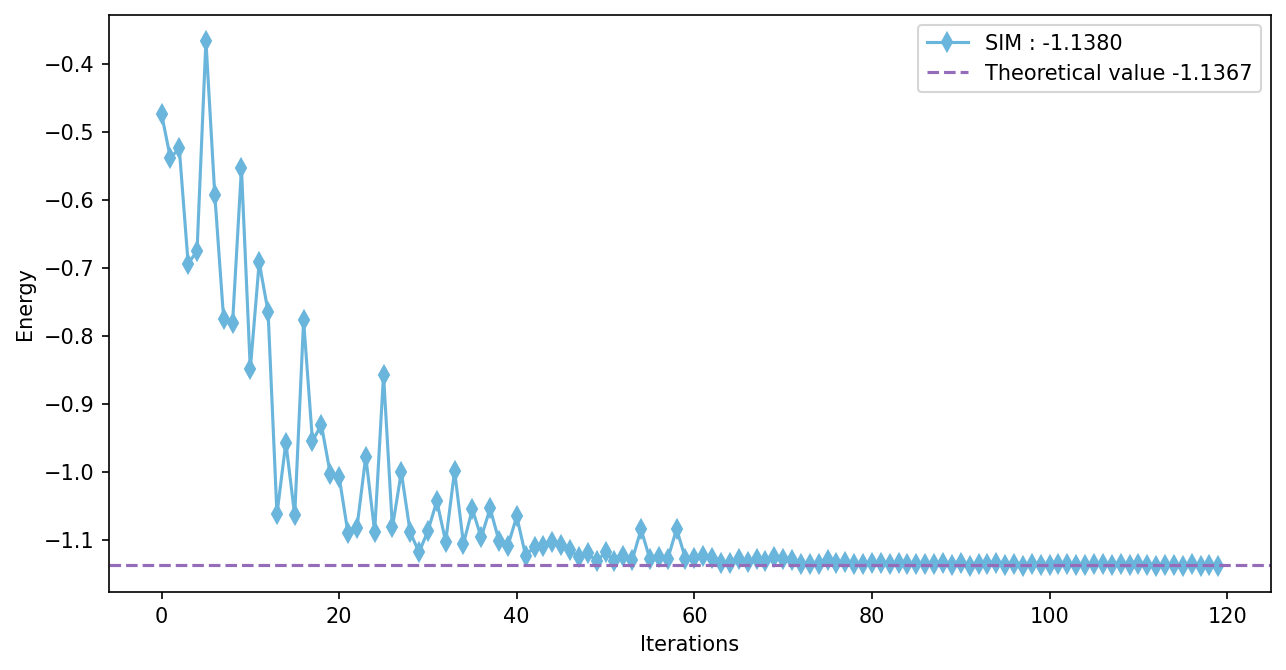

init_param = [1.88049275, 0.13030553, 2.34082327, 1.66621732, 1.70068762, 2.05938886, 1.77366577, 0.13684104, 0.51453294, 0.6594264, 5.45053489, 3.97656782, 3.84236729, 4.49736331, 4.54771989, 0.4024555, 1.20773188, 1.30513132, 4.41747557, 3.07358369]


-1.1380078841020207

In [12]:
VQE(h_names=h_names, h_weights=h_weights, Local=True)

## References

[1] A. Peruzzo, J. McClean, P. Shadbolt, M.-H. Yung, X.-Q. Zhou, P. J. Love,A. Aspuru-Guzik, and J. L. O’Brien, “A variational eigenvalue solver on a photonicquantum processor”, [Nature Communications](https://www.nature.com/articles/ncomms5213) 5, 4213 (2014).

[2] J. Tilly, H. Chen, S. Cao, et al., “The variational quantum eigensolver: a review of methods and best practices”. [Physics Reports](https://www.sciencedirect.com/science/article/pii/S0370157322003118), 2022, vol. 986, p. 1-128.

[3] J. McClean, N. Rubin, K. Sung, et al., “Openfermion: the electronic structure package for quantum computers”. [Quantum Science and
Technology](https://iopscience.iop.org/article/10.1088/2058-9565/ab8ebc)(3):034014, 2020.